#### Recomendation Systems

Dataset columns - first three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.

In [11]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
# from sklearn.externals import joblib
# import Recommenders as Recommenders
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

#Q1- Read and explore the given dataset.  ( Rename column/add headers, plot histograms, find data characteristics)

In [12]:
# Load Data
df = pd.read_csv('ratings_Electronics.csv', header=None)
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
df.head()

,user_id,prod_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [13]:
df.shape

(7824482, 4)

In [14]:
df.dtypes

user_id       object
prod_id       object
rating       float64
timestamp      int64
dtype: object

In [15]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
user_id      object
prod_id      object
rating       float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


user_id      0
prod_id      0
rating       0
timestamp    0
dtype: int64

Inference:
- Total number of records(Rows) in the given dataset is 7824482 with four columns.
- There are no  missing 
- UserId and Product Id are of data type objects 
- Rating is of type float
- time stamp is of type integer. However we can discard the time stamp from dataset as this is not significant for our usecase.

In [16]:
dfNew = df.drop("timestamp", axis = 1)
dfNew.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [17]:
dfNew.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


In [18]:
print("Number of unique Users : ",len(dfNew.user_id.unique()))      
print("Number of unique Products", len(dfNew.prod_id.unique()))

Number of unique Users :  4201696
Number of unique Products 476002


Inference:
    - Number of unique Users :  4201696
    - Number of unique Products 476002
    - The minumum rating is 1 and maximum rating is 5, so from this we can assume that ratings are give in the scale of 1 to 5 

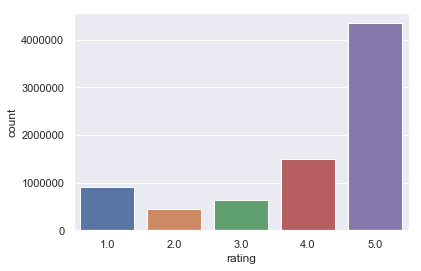

In [19]:
# Distribution of Ratings

sns.set(style="darkgrid")
ax = sns.countplot(x="rating", data=dfNew)


#Q2 - Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )

In [20]:
users = dfNew['user_id'].value_counts()
dfUpdated = dfNew[dfNew['user_id'].isin(users[users >= 50].index)]

dfUpdated.head()


,user_id,prod_id,rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [21]:
print("Number if users who have rated greaterthan or equal to 50 :", len(dfUpdated)) #.count())
print("Unique number of Items :", len(dfUpdated.prod_id.unique()))
print("Unique number of Users :", len(dfUpdated.user_id.unique()))


Number if users who have rated greaterthan or equal to 50 : 125871
Unique number of Items : 48190
Unique number of Users : 1540


In [22]:
#Going forward "dfUpdated" dataset will be used throught the project
dfUpdated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125871 entries, 94 to 7824444
Data columns (total 3 columns):
user_id    125871 non-null object
prod_id    125871 non-null object
rating     125871 non-null float64
dtypes: float64(1), object(2)
memory usage: 3.8+ MB


In [23]:
dfUpdated.shape

(125871, 3)

In [24]:
dfUpdated.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,125871.0,4.261339,1.062144,1.0,4.0,5.0,5.0,5.0


#3 - Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)

In [25]:
train_data, test_data = train_test_split(dfUpdated, test_size = 0.3, random_state=0)
train_data.head(5)

,user_id,prod_id,rating
6595853,A2BYV7S1QP2YIG,B009EAHVTA,5.0
4738241,AB094YABX21WQ,B0056XCEAA,1.0
4175596,A3D0UM4ZD2CMAW,B004I763AW,5.0
3753016,AATWFX0ZZSE6C,B0040NPHMO,3.0
1734767,A1NNMOD9H36Q8E,B0015VW3BM,4.0


In [26]:
train_data.shape

(88109, 3)

In [27]:
test_data.shape

(37762, 3)

#Q4 - Build Popularity Recommender model.

In [34]:
# Group the dataset based on propularity of product among Users and sort by user id:

df_train_grouped = train_data.groupby(['prod_id']).agg({'user_id': 'count'}).reset_index()
df_tarin_sorted = df_train_grouped.sort_values(['user_id','prod_id'], ascending=[0,1])
# Top 5 Recomendation ID
popular_items = df_tarin_sorted.head(5)


In [37]:
# Function to return popular item. As this is not a personalised one this function returns the most popular items based on 
# user crowd ratings on a product

def recomend_items(userid):
    recommendations = popular_items 
    recommendations['user_id'] = userid 
    return recommendations 
    

In [38]:
recomend_items('A2NWSAGRHCP8N5')

,prod_id,user_id
30847,B0088CJT4U,A2NWSAGRHCP8N5
30287,B007WTAJTO,A2NWSAGRHCP8N5
19647,B003ES5ZUU,A2NWSAGRHCP8N5
8752,B000N99BBC,A2NWSAGRHCP8N5
30555,B00829THK0,A2NWSAGRHCP8N5


#Q5 - Build Collaborative Filtering model.
#Q7 - Get top - K ( K = 5) recomendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [42]:
#Creating a sparse pivot table with users in rows and items in columns
pivot_matrix_df = dfUpdated.pivot(index='user_id', 
                                                          columns='prod_id', 
                                                          values='rating').fillna(0)

pivot_matrix_df.head(10)

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10H24TDLK2VDP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10NMELR4KX0J6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10O7THJ2O20AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10PEXB6XAQ5XF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
pivot_matrix_df['index'] = np.arange(0, pivot_matrix_df.shape[0], 1)
pivot_matrix_df.head()
pivot_matrix_df.set_index(['index'], inplace=True)

# Actual ratings given by users
pivot_matrix_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_id
index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [47]:
from scipy.sparse.linalg import svds

In [50]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 5
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(pivot_matrix_df, k = NUMBER_OF_FACTORS_MF)

In [52]:
U.shape

(1540, 5)

In [56]:
Vt.shape


(5, 48191)

In [60]:
sigma = np.diag(sigma)
sigma.shape

(5, 5)

In [62]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[-1.61339810e-04,  8.01584432e-04,  3.33197802e-03, ...,
         6.38444232e-02,  1.29010855e-02,  4.58130185e-03],
       [-3.28594296e-03, -3.46540384e-03,  5.71688113e-03, ...,
        -6.52362452e-03,  2.39510934e-04,  1.00512331e+00],
       [-4.38283701e-03, -5.38183270e-03,  3.36636563e-03, ...,
        -1.24329176e-02, -5.37591812e-03,  2.00203447e+00],
       ...,
       [ 7.49876010e-03,  1.12286800e-02,  7.63476667e-03, ...,
         2.99511647e-01,  5.50957483e-02,  1.53700086e+03],
       [ 6.74912766e-03,  6.40816633e-03, -1.97587755e-04, ...,
         2.55822716e-03,  1.77193215e-03,  1.53799651e+03],
       [ 8.25040430e-03,  7.39821415e-03, -2.28712189e-03, ...,
        -7.08262626e-03,  5.19030706e-04,  1.53899598e+03]])

In [89]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_matrix_df.columns)
cf_preds_df.head(10)


prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_id
0,-0.000161,0.000802,0.003332,0.003478,-0.003502,-0.000177,0.001084,-0.000240,0.003720,-0.000133,...,0.051113,0.000289,0.067347,0.002955,0.006171,-0.001825,0.164417,0.063844,0.012901,0.004581
1,-0.003286,-0.003465,0.005717,0.005696,-0.005195,-0.004223,0.009562,0.000741,-0.006922,-0.003646,...,0.021939,-0.004750,-0.008327,0.005362,-0.003865,-0.004181,-0.012103,-0.006524,0.000240,1.005123
2,-0.004383,-0.005382,0.003366,0.007700,-0.003053,-0.005625,0.005837,0.002419,-0.014567,-0.004664,...,0.013850,-0.006509,-0.019752,0.016847,-0.004634,-0.004572,-0.012522,-0.012433,-0.005376,2.002034
3,0.000348,0.000657,0.001558,0.000085,-0.001373,0.000382,0.002782,-0.000700,0.003367,0.000243,...,0.004420,0.000459,0.002520,-0.004936,-0.000169,-0.000127,-0.004206,0.000442,0.002543,3.003907
4,-0.001897,-0.002427,0.002235,0.005002,-0.001980,-0.002586,0.004558,0.001008,-0.005508,-0.002162,...,0.005341,-0.003119,-0.014909,0.006590,-0.003008,-0.002306,-0.018357,-0.011173,-0.002222,4.002667
5,-0.003688,-0.004060,0.003773,0.003538,-0.003321,-0.004508,0.005827,0.001312,-0.010852,-0.003825,...,0.015444,-0.004973,-0.010446,0.009312,-0.003477,-0.003704,-0.013960,-0.007574,-0.003015,5.002233
6,-0.000063,0.000291,0.001686,-0.000311,-0.001457,-0.000036,0.002422,-0.000544,0.001887,-0.000104,...,0.008068,0.000090,0.006772,-0.003488,0.000164,-0.000402,0.005751,0.004561,0.002539,6.006504
7,0.000604,0.001842,0.003910,-0.002254,-0.003539,0.000935,0.004709,-0.001865,0.007701,0.000591,...,0.024762,0.001511,0.031178,-0.011474,0.002302,-0.000373,0.041460,0.023596,0.009110,7.012036
8,-0.002246,-0.003068,0.002811,0.010324,-0.002652,-0.003312,0.005071,0.001856,-0.006523,-0.002674,...,0.018221,-0.004097,-0.003771,0.013575,-0.002172,-0.003434,0.031424,0.002999,-0.000105,8.005305
9,0.000465,0.000448,0.001672,0.004566,-0.001526,0.000212,0.003331,-0.000122,0.003693,0.000179,...,0.008957,0.000028,0.004644,-0.000601,-0.000028,-0.000646,0.019706,0.005332,0.003576,9.007290


In [92]:
def recommend_items_CF(userId, pivot_matrix_df, cf_preds_df, num_recommendations):
      
    user_idx = userId-1
    sorted_user_ratings = pivot_matrix_df.iloc[user_idx].sort_values(ascending=False)
    sorted_user_predictions = cf_preds_df.iloc[user_idx].sort_values(ascending=False)
    result = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    result.index.name = 'Recommended Products'
    result.columns = ['user_ratings', 'user_predictions']
    result = result.loc[result.user_ratings == 0]   
    result = result.sort_values('user_predictions', ascending=False)
    return result.head(num_recommendations)


In [121]:
# Call Collaborative recomendation method:
userId = 100
num_recommendations = 5
result = recommend_items_CF(userId, pivot_matrix_df, cf_preds_df, num_recommendations)
print("Recommendation for UserId :")
print(result)

Recommendation for UserId :
                      user_ratings  user_predictions
Recommended Products                                
B003ES5ZUU                     0.0          0.215482
B007WTAJTO                     0.0          0.192105
B00829THK0                     0.0          0.114075
B002V88HFE                     0.0          0.113896
B009SYZ8OC                     0.0          0.105332


In [122]:
# Call Collaborative recomendation method:
userId = 200
num_recommendations = 5
result = recommend_items_CF(userId, pivot_matrix_df, cf_preds_df, num_recommendations)
print("Recommendation for UserId :")
print(result)

Recommendation for UserId :
                      user_ratings  user_predictions
Recommended Products                                
B0079UAT0A                     0.0          0.882380
B004CLYEFK                     0.0          0.789283
B0088CJT4U                     0.0          0.586545
B008ULPE70                     0.0          0.584715
B004CLYEDC                     0.0          0.578944


#Q6 - Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models.

In [116]:
# Evaluate Popularity and Collaborative by computing RMSE
# 1 - dfUpdated, 2 - cf_preds_df

dfUpdated_matrix = dfUpdated.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)

# dfUpdated_matrix.head().mean().head()
# cf_preds_df.mean().head()

df_rmse = pd.concat([dfUpdated_matrix.mean(), cf_preds_df.mean()],axis=1)
df_rmse.columns = ['Actual Ratings', 'Predicted Ratings']
df_rmse.head()

,Actual Ratings,Predicted Ratings
0594451647,0.003247,0.002656
0594481813,0.001948,0.002498
0970407998,0.003247,0.001432
0972683275,0.012338,0.010609
1400501466,0.012987,0.009440


In [120]:
RMSE = round((((df_rmse['Actual Ratings'] - df_rmse['Predicted Ratings']) ** 2).mean() ** 0.5), 5)
print("RMSE :", RMSE)

RMSE : 0.00291


# Insights

#Popularity Recommender model - is based on popularity of products among users. The suggested/recomended output of the model will be the same irespective of the user. This is not a personalised recomenadtion model

#Collaborative Filtering model - is a personalisesd recomendation model. From the output of the model you can see that the output is differnt for differnt users, however it is not the same in case if popularity based model.